# Analyze field interpolation an warping errors

In [1]:
# fix python imports relative paths issues
%cd ../../

/mnt/asgard2/code/nadim/repo/DIRV-Net


In [2]:
# auto reload imports if they been modified

%load_ext autoreload
%autoreload 2

In [3]:
# limit TF GPU memory usage

from source.framework.tools.gpu_tools import config_gpu

config_gpu(gpu_index=1, memory_limit_gb=None)

2024-05-22 20:00:55.464546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 20:00:56.427952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 20:00:56.428206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 20:00:56.434129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import tensorflow as tf

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

In [5]:
from source.framework.settings.whole_config import WholeConfig
from source.framework.settings.synthetic_fields_provider import SyntheticFieldsProvider

from source.framework.tools.plotting_helper import (
    heat_map_drawer,
    grid_figure,
    setup_grid_figure_color_bar,
)
from source.framework.tools.gradient_chessboard_generator import (
    random_gradient_chessboard,
)

from source.model.tools.operators.upgrading_operator import UpgradingOperator
from source.model.tools.operators.resizing_operator import (
    ResizingOperator,
    ResizingMethods,
)
from source.model.tools.operators.sampling_operator import sample

from source.model.tools.shape_break_down import ShapeBreakDown

from source.model.tools.operators.warping_operator import warp_images

from source.framework.settings.enums import SyntheticFields, Stages

In [6]:
cell_size = 4
image_size_2d = 64
rank = 2


def get_img():
    return random_gradient_chessboard(
        output_size=[image_size_2d] * rank,
        random_cells_size_range=(cell_size, cell_size + 1),
        channels_count=1,
    )

In [7]:
config = WholeConfig("delete")
config.images_rank = rank

In [8]:
def array_to_tensor(array):
    tensor = tf.convert_to_tensor(array, dtype=config.float_data_type)
    tensor = tf.expand_dims(tensor, axis=0)
    return tensor


def tensor_to_array(tensor):
    return tensor[0, ...].numpy()

In [13]:
field_gen = SyntheticFieldsGenerator(config, Stages.TRAINING)
resizer = ResizingOperator(
    config.images_rank,
    config.displacements_to_flows_resizing_up_method,
)


def calc_flows_info(config):
    # config.global_random_seed = datetime.now().microsecond
    empty_tensor = tf.zeros((1, 64, 64, 1))

    flow_fields = field_gen.generate(ShapeBreakDown(empty_tensor))
    displacement_fields = sample(
        flow_fields, config.displacements_control_points_spacings
    )

    interpolated_displacement_fields = resizer.make_like(
        displacement_fields, flow_fields
    )

    diff = flow_fields - interpolated_displacement_fields
    diff_max = tf.reduce_max(tf.abs(diff))
    diff_avg = tf.math.reduce_mean(tf.abs(diff))
    max_original = tf.reduce_max(tf.abs(flow_fields))

    return (
        diff_max.numpy(),
        diff_avg.numpy(),
        max_original.numpy(),
        diff,
        flow_fields,
        displacement_fields,
        interpolated_displacement_fields,
    )


def calc_images_info(img, flow_fields, interpolated_displacement_fields):
    warped_original, _ = warp_images(array_to_tensor(img), flow_fields)
    warped_original = tensor_to_array(warped_original)

    warped_interpolated, _ = warp_images(
        array_to_tensor(img), interpolated_displacement_fields
    )
    warped_interpolated = tensor_to_array(warped_interpolated)

    diff = warped_original - warped_interpolated

    diff_max = tf.reduce_max(tf.abs(diff))
    diff_avg = tf.math.reduce_mean(tf.abs(diff))

    return (
        diff_max.numpy(),
        diff_avg.numpy(),
        warped_original,
        warped_interpolated,
        diff,
    )

2024-05-11 21:17:24.371235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


Max. Diff. 2.782468
Avg. Diff. 0.6669713
Max. Orig. 13.454492
Max. Error %  20.680588758607936
Avg. Error %  4.957239150649873


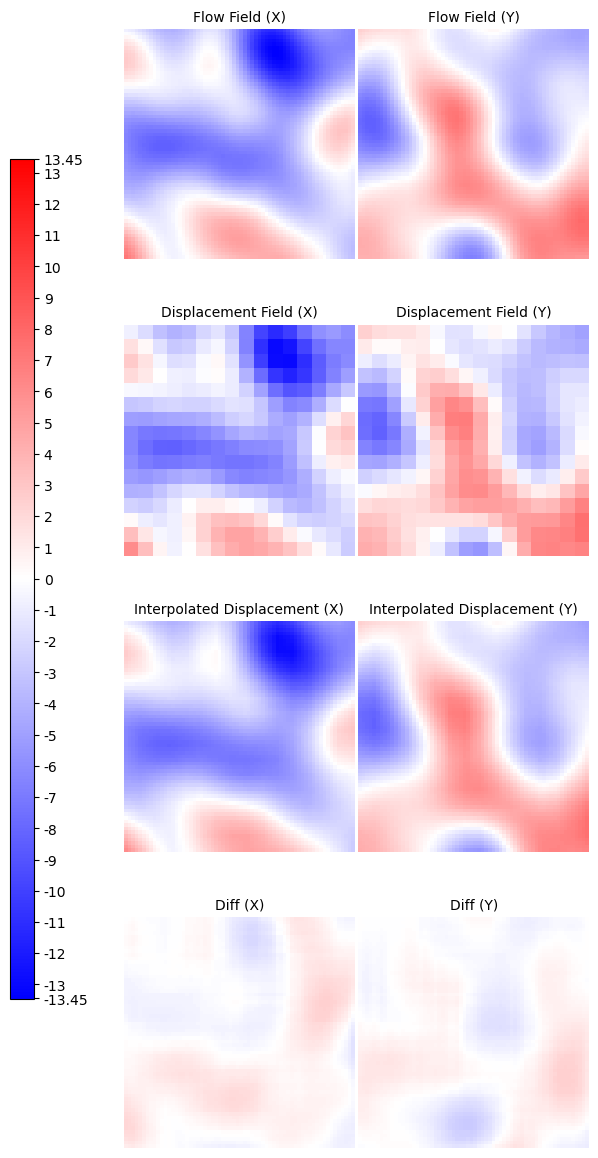

In [14]:
(
    diff_max,
    diff_avg,
    max_original,
    diff,
    flow_fields,
    displacement_fields,
    interpolated_displacement_fields,
) = calc_flows_info(config)

print("Max. Diff.", diff_max)
print("Avg. Diff.", diff_avg)
print("Max. Orig.", max_original)
print("Max. Error % ", 100 * diff_max / max_original)
print("Avg. Error % ", 100 * diff_avg / max_original)


def cell_drawers(h, w):
    if h == 0:
        return heat_map_drawer(
            flow_fields[0, ..., w].numpy(),
            title="Flow Field (X)" if w == 0 else "Flow Field (Y)",
            color_map_min_val=-max_original,
            color_map_max_val=max_original,
            color_map_name=config.displacements_preview_color_map,
        )
    elif h == 1:
        return heat_map_drawer(
            displacement_fields[0, ..., w].numpy(),
            title="Displacement Field (X)" if w == 0 else "Displacement Field (Y)",
            color_map_min_val=-max_original,
            color_map_max_val=max_original,
            color_map_name=config.displacements_preview_color_map,
        )
    elif h == 2:
        return heat_map_drawer(
            interpolated_displacement_fields[0, ..., w].numpy(),
            title="Interpolated Displacement (X)"
            if w == 0
            else "Interpolated Displacement (Y)",
            color_map_min_val=-max_original,
            color_map_max_val=max_original,
            color_map_name=config.displacements_preview_color_map,
        )
    else:
        return heat_map_drawer(
            diff[0, ..., w].numpy(),
            title="Diff (X)" if w == 0 else "Diff (Y)",
            color_map_min_val=-max_original,
            color_map_max_val=max_original,
            color_map_name=config.displacements_preview_color_map,
        )


figure, plots = grid_figure(
    grid_shape=(4, 2),
    cell_drawers=cell_drawers,
    cell_size_inches=config.vector_fields_logging_cell_size_inches,
)

setup_grid_figure_color_bar(
    figure,
    grid_columns_count=2,
    reference_image=plots[1, 1],
    color_map_min_val=-max_original,
    color_map_max_val=max_original,
)

Max. Diff. 86.95862
Avg. Diff. 8.266301
Max. Orig. 13.454492
Max. Error %  34.101418887867645
Avg. Error %  3.2416867274864045


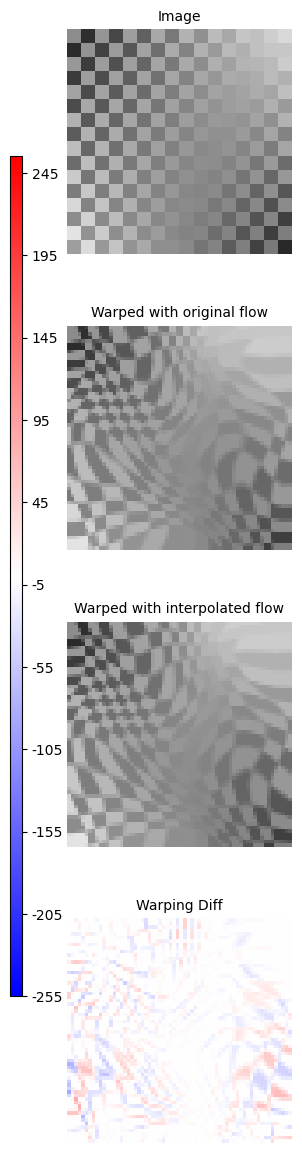

In [17]:
resized = get_img()

diff_max, diff_avg, warped_original, warped_interpolated, diff = calc_images_info(
    resized, flow_fields, interpolated_displacement_fields
)


def cell_drawers(h, w):
    if h == 0:
        return heat_map_drawer(
            resized,
            title="Image",
            display_grid=False,
            display_axis=False,
            title_font_size=None,
            color_map_name=config.images_preview_color_map,
            color_map_min_val=0,
            color_map_max_val=255,
        )
    if h == 1:
        return heat_map_drawer(
            warped_original,
            title="Warped with original flow",
            display_grid=False,
            display_axis=False,
            title_font_size=None,
            color_map_name=config.images_preview_color_map,
            color_map_min_val=0,
            color_map_max_val=255,
        )
    elif h == 2:
        return heat_map_drawer(
            warped_interpolated,
            title="Warped with interpolated flow",
            display_grid=False,
            display_axis=False,
            title_font_size=None,
            color_map_name=config.images_preview_color_map,
            color_map_min_val=0,
            color_map_max_val=255,
        )
    else:
        return heat_map_drawer(
            diff,
            title="Warping Diff",
            display_grid=False,
            display_axis=False,
            title_font_size=None,
            color_map_name=config.images_diff_preview_color_map,
            color_map_min_val=-255,
            color_map_max_val=255,
        )


print("Max. Diff.", diff_max)
print("Avg. Diff.", diff_avg)
print("Max. Orig.", max_original)
print("Max. Error % ", 100 * diff_max / 255)
print("Avg. Error % ", 100 * diff_avg / 255)

figure, plots = grid_figure(
    grid_shape=(4, 1),
    cell_drawers=cell_drawers,
    cell_size_inches=config.vector_fields_logging_cell_size_inches,
)

setup_grid_figure_color_bar(
    figure,
    grid_columns_count=2,
    reference_image=plots[3, 0],
    color_map_min_val=-255,
    color_map_max_val=255,
    step=50,
)

In [18]:
fields_diff_max_percentage = []
fields_diff_avg_percentage = []

images_diff_max = []
images_diff_avg = []

for _ in range(200):
    (
        diff_max,
        diff_avg,
        max_original,
        _,
        flow_fields,
        _,
        interpolated_displacement_fields,
    ) = calc_flows_info(config)

    fields_diff_max_percentage.append(diff_max / max_original * 100)
    fields_diff_avg_percentage.append(diff_avg / max_original * 100)

    resized = get_img()
    diff_max, diff_avg, _, _, _ = calc_images_info(
        resized, flow_fields, interpolated_displacement_fields
    )

    images_diff_max.append(diff_max)
    images_diff_avg.append(diff_avg)

print(
    "Max. Diff. %",
    np.max(fields_diff_max_percentage),
    "-",
    np.std(fields_diff_max_percentage),
)
print(
    "Max. Avg. Diff. %",
    np.max(fields_diff_avg_percentage),
    "-",
    np.std(fields_diff_avg_percentage),
)

print(
    "Max. Diff. %",
    np.max(images_diff_max) * 100 / 255,
    "-",
    np.std(images_diff_max) * 100 / 255,
)
print(
    "Max. Avg. Diff. %",
    np.max(images_diff_avg) * 100 / 255,
    "-",
    np.std(images_diff_avg) * 100 / 255,
)

Max. Diff. % 50.803256034851074 - 6.21059048776225
Max. Avg. Diff. % 9.219834953546524 - 1.0568593491430573
Max. Diff. % 93.33333333333333 - 17.586746215820312
Max. Avg. Diff. % 13.456586949965534 - 2.4259382135727825
